# Importing the Libraries

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import tensorflow as tf


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
data = pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv" , index_col=0)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
data = data.drop(['Title', 'Clothing ID', 'Positive Feedback Count'], axis=1)
data.head()

,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses


In [6]:
# Checking for the missing values
count_NaN = data.isna().sum()
count_NaN

Age                  0
Review Text        845
Rating               0
Recommended IND      0
Division Name       14
Department Name     14
Class Name          14
dtype: int64

**It is impossible to replace the Review Text features. Therefore, I will drop the missing rows from the dataset.**

In [7]:
# Dropping the missing values in the rows
data = data.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'], axis=0)
data = data.reset_index(drop=True)

# Checking for the missing values after the drops
count_NaN_updated = data.isna().sum()
count_NaN_updated

Age                0
Review Text        0
Rating             0
Recommended IND    0
Division Name      0
Department Name    0
Class Name         0
dtype: int64

# Distribution of the Ratings

In [8]:
fig = px.histogram(data['Rating'],
                   labels={'value': 'Rating',
                           'count': 'Frequency',
                           'color': 'Rating'}, color=data['Rating'])
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Ratings',
                  title_x=0.5, title_font=dict(size=20))
fig.show()

**According to the graph above, frequency of the Rating 5 is pretty high compared to the others.**

# Distribution of the Recommendations

In [10]:
labels = ['Recommended', 'Not Recommended']
values = [data[data['Recommended IND'] == 1]['Recommended IND'].value_counts()[1],
          data[data['Recommended IND'] == 0]['Recommended IND'].value_counts()[0]]
colors = ['green', 'red']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, opacity=0.8)])
fig.update_traces(textinfo='percent+label', marker=dict(line=dict(color='#000000', width=2), colors=colors))
fig.update_layout(title_text='Distribution of the Recommendations', title_x=0.5, title_font=dict(size=20))
fig.show()

**According to this pie chart, the most of the sales are Recommended.**

# Relationship between Ratings and Recommendation

In [12]:
fig = px.histogram(data['Rating'], color=data['Recommended IND'],
                   labels={'value': 'Rating',
                           'color': 'Recommended?'})
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Relationship between Ratings and Recommendation',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='group')
fig.show()

**According to this graph above, almost all the Rating 5 and Rating 4 data points are recommended.**

**In addition, Rating 1 and Rating 2 data points have almost no recommendations.**

**For the further steps, I would create a common rating point with the Rating 4 and Rating 5 as well as Rating 1 and Rating 2. In this way, I would shrink the labels therefore, the model would perform better.**

# <center> Data Preprocessing

**In this step I will be dealing with the cleaning text data.**

In [18]:
# Lower Character all the Texts
data['Review Text'] = data['Review Text'].str.lower()
data['Review Text'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress!  it's sooo pretty.  i happene...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [19]:
# Removing Punctuations and Numbers from the Text
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


data['Review Text'] = data['Review Text'].apply(remove_punctuations_numbers)

**In this section, I will remove all punctuations and numbers from the all dataframe. They will be not usefull for my model training.**

# Tokenizing with NLTK

In [20]:
import nltk
nltk.download('punkt')
def tokenization(inputs):  # Ref.1
    return word_tokenize(inputs)


data['text_tokenized'] = data['Review Text'].apply(tokenization)
data['text_tokenized'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    [absolutely, wonderful, silky, and, sexy, and,...
1    [love, this, dress, it, s, sooo, pretty, i, ha...
2    [i, had, such, high, hopes, for, this, dress, ...
3    [i, love, love, love, this, jumpsuit, it, s, f...
4    [this, shirt, is, very, flattering, to, all, d...
Name: text_tokenized, dtype: object

**Tokenizing with NLTK will help me to clean the dataset for better model training.**

# Stopwords Removal

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def stopwords_remove(inputs):  # Ref.2
    return [k for k in inputs if k not in stop_words]


data['text_stop'] = data['text_tokenized'].apply(stopwords_remove)
data['text_stop'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hopes, dress, really, wanted, work, ini...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: text_stop, dtype: object

# Lemmatization

In [22]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def lemmatization(inputs):  # Ref.1
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]


data['text_lemmatized'] = data['text_stop'].apply(lemmatization)
data['text_lemmatized'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happen, find, stor...
2    [high, hop, dress, really, want, work, initial...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flatter, due, adjustable, front, tie, ...
Name: text_lemmatized, dtype: object

In [23]:
# Removing Words less than length 2
def remove_less_than_2(inputs):  # Ref.1
    return [j for j in inputs if len(j) > 2]


data['final'] = data['text_lemmatized'].apply(remove_less_than_2)

In [24]:
# Joining Tokens into Sentences
data['final'] = data['final'].str.join(' ')
data['final'].head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hop dress really want work initially orde...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: final, dtype: object

# WordCloud of the Recommended Reviews

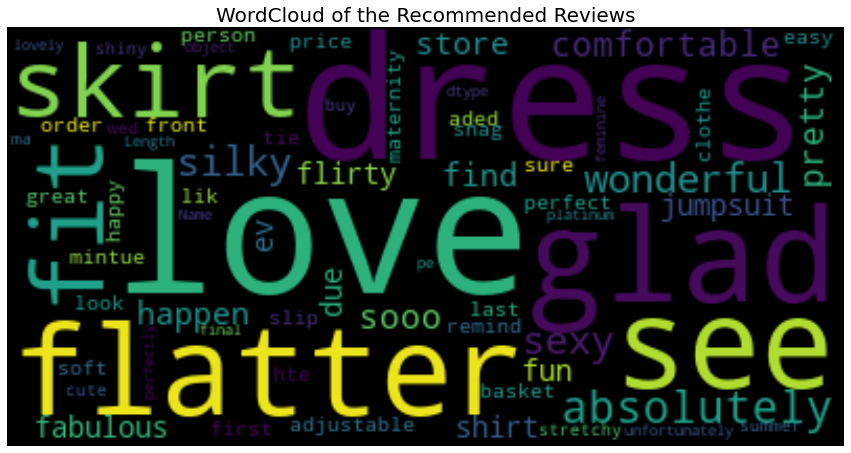

In [26]:
data_recommended = data[data['Recommended IND'] == 1]  # Dataframe that only includes recommended reviews
data_not_recommended = data[data['Recommended IND'] == 0]  # # Dataframe that only includes not recommended reviews

WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((data_recommended['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

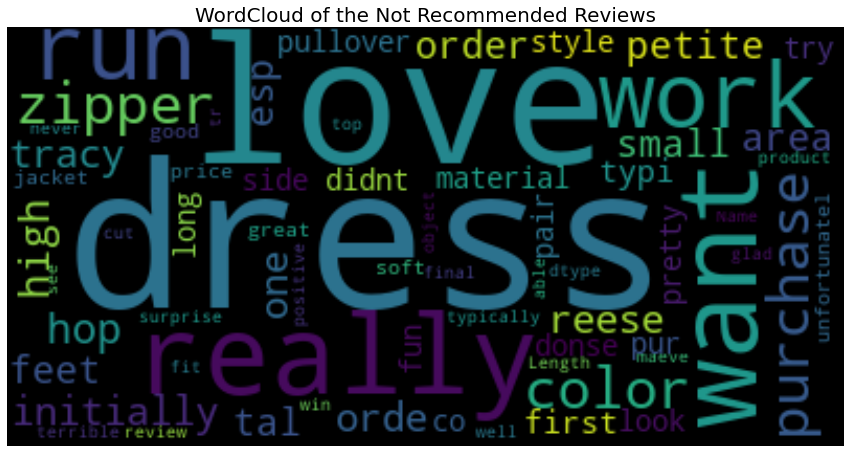

In [28]:
WordCloud_not_recommended = WordCloud(max_words=500,
                                      random_state=30,
                                      collocations=True).generate(str((data_not_recommended['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_not_recommended, interpolation='bilinear')
plt.title('WordCloud of the Not Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

# Train-Test-Validation Split


In [31]:
# I will only use Text data to predict Recommendation
y = data['Recommended IND']
X = data['final']

X.head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hop dress really want work initially orde...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: final, dtype: object

In [32]:
# Train-Test-Validation Split
x, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=13)  # Test: %20

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=13)  # Val: %20

print('Shape of the X_train:', X_train.shape)
print('Shape of the X_test:', X_test.shape)
print('Shape of the X_val:', X_val.shape)
print('--'*20)
print('Shape of the y_train:', y_train.shape)
print('Shape of the y_test:', y_test.shape)
print('Shape of the y_val:', y_val.shape)

Shape of the X_train: (13576,)
Shape of the X_test: (4526,)
Shape of the X_val: (4526,)
----------------------------------------
Shape of the y_train: (13576,)
Shape of the y_test: (4526,)
Shape of the y_val: (4526,)


# Tokenizing with Tensorflow


In [33]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_val = tokenizer.texts_to_sequences(X_val)

print('Non-tokenized Version: ', X_train[0])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[0]]))
print('--'*20)
print('Non-tokenized Version: ', X_train[80])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[80]]))

Non-tokenized Version:  absolutely wonderful silky sexy comfortable
Tokenized Version:  [[161, 366, 748, 445, 33]]
----------------------------------------
Non-tokenized Version:  usually petite since dress not come petites try fit lbs dress hit knee hem bite not overwhelm dress look stun great vibrant color dark hair make classic elegant dress look contemporary stylish try store salesperson others happen see rave tell grab glad plan wear spring daughte
Tokenized Version:  [[61, 47, 150, 2, 7, 109, 769, 23, 3, 68, 2, 146, 269, 223, 38, 7, 746, 2, 8, 397, 12, 356, 11, 278, 1025, 18, 342, 459, 2, 8, 2151, 344, 23, 57, 1885, 350, 601, 62, 1723, 432, 631, 218, 313, 6, 212, 6315]]


# Padding the Datasets


In [34]:
maxlen = 50
Padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
Padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

# <center> ANN Model Creation


In [35]:
# Creating the Model
model = Sequential()

model.add(Embedding(num_words, 16, input_length=maxlen))
model.add(Dropout(0.2))

model.add(GlobalAvgPool1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(lr=0.55e-3)  # Learning Rate

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [36]:
# Training the Model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,
                                                  restore_best_weights=True)

epochs = 100
hist = model.fit(Padded_train, y_train, epochs=epochs,
                 validation_data=(Padded_val, y_val),
                 callbacks=[early_stopping], batch_size=32)

Epoch 1/100
425/425 [==============================] - 3s 5ms/step - loss: 0.5579 - accuracy: 0.8036 - val_loss: 0.4640 - val_accuracy: 0.8239
Epoch 2/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4636 - accuracy: 0.8201 - val_loss: 0.4387 - val_accuracy: 0.8239
Epoch 3/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4421 - accuracy: 0.8201 - val_loss: 0.4213 - val_accuracy: 0.8239
Epoch 4/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4250 - accuracy: 0.8201 - val_loss: 0.4037 - val_accuracy: 0.8239
Epoch 5/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4062 - accuracy: 0.8202 - val_loss: 0.3851 - val_accuracy: 0.8248
Epoch 6/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3861 - accuracy: 0.8215 - val_loss: 0.3647 - val_accuracy: 0.8270
Epoch 7/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3657 - accuracy: 0.8260 - val_loss: 0.3454 - val_accuracy: 0.8332

# Preparing the Test Data


In [39]:
X_test = X_test.apply(tokenization)
X_test = X_test.apply(stopwords_remove)
X_test = X_test.apply(lemmatization)
X_test = X_test.str.join(' ')

X_test.head()

10818                              low waisted weird liner
779      shirt not good look gal hips fit top tight ord...
10907    love dress long enough dramatic graze feet wit...
17442    understand pencil skirt gon body hug however r...
832      order shirt wear pair pant return one reason t...
Name: final, dtype: object

In [40]:
Tokenized_test = tokenizer.texts_to_sequences(X_test)
Padded_test = pad_sequences(Tokenized_test, maxlen=maxlen, padding='pre')

test_evaluate = model.evaluate(Padded_test, y_test)

142/142 [==============================] - 0s 1ms/step - loss: 0.2673 - accuracy: 0.8889


# Evaluation Metrics of the LSTM Model

In [43]:
# Accuracy
train_acc_lstm = round(accuracy_score(y_train, pred_train_lstm) * 100, 2)
print('Train Accuracy of the LSTM: %', train_acc_lstm)
test_acc_lstm = round(accuracy_score(y_test, pred_test_lstm) * 100, 2)
print('Test Accuracy of the LSTM: %', test_acc_lstm)
print('--' * 20)

# Precision
train_precision_lstm = round(precision_score(y_train, pred_train_lstm) * 100, 2)
print('Train Precision of the LSTM: %', train_precision_lstm)
precision_lstm = round(precision_score(y_test, pred_test_lstm) * 100, 2)
print('Test Precision of the LSTM: %', precision_lstm)
print('--' * 20)

# Recall
train_recall_lstm = round(recall_score(y_train, pred_train_lstm) * 100, 2)
print('Train Recall of the LSTM: %', train_recall_lstm)
recall_lstm = round(recall_score(y_test, pred_test_lstm) * 100, 2)
print('Test Recall of the LSTM: %', recall_lstm)

Train Accuracy of the LSTM: % 92.04
Test Accuracy of the LSTM: % 88.91
----------------------------------------
Train Precision of the LSTM: % 93.77
Test Precision of the LSTM: % 91.09
----------------------------------------
Train Recall of the LSTM: % 96.72
Test Recall of the LSTM: % 95.66


In [44]:
def predict_recommendation(input_text):  # The function for doing all the previous steps
    input_text = input_text.lower()
    input_text = re.sub(r'[^a-zA-Z]', ' ', input_text)
    input_text = tokenization(input_text)
    input_text = stopwords_remove(input_text)
    input_text = lemmatization(input_text)
    input_text = ' '.join(input_text)
    input_text = tokenizer.texts_to_sequences([input_text])
    input_text = pad_sequences(input_text, maxlen=maxlen, padding='pre')
    input_text = model.predict(input_text)
    if input_text >= 0.5:
        input_text = f'Recommended with %{round(float(input_text*100), 2)}'
    else:
        input_text = f'Not Recommended with %{round(float(input_text*100), 2)}'

    return print(input_text)

In [51]:
predict_recommendation("I have no complaints whatsoever, from ordering to getting my goods were excellent , down to the garments themselves, was as good as you see them on the website, I have shopped on here a few times and not disappointed at all, the only problem I have is that some trousers are a bit slim on leg and because I am a below knee amputee I have difficulty getting the right fit, otherwise very happy indeed.")

Recommended with %91.63


In [52]:
predict_recommendation("My dress had blue ink and biro stains on which was a real shame. I needed it for an outfit so had to put up with it but I'm not sure I'll order online again.")

Not Recommended with %42.32


In [53]:
# Ref. 6 from now on
predict_recommendation("Sizes varied despite allegedly being the same size. Some of the quality was poor. I had to send most of my order back (including the jeans I didn't order) Usually I get good stuff from Yours, so I was disappointed")

Not Recommended with %17.44


In [59]:
predict_recommendation("The dress does not look like the dress pictures. The material seems cheaper and this does not fit well.")

Not Recommended with %2.83
